In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from tqdm import tqdm

# Load dataset
data = pd.read_csv('./DatasetCombined.csv', encoding='ISO-8859-1')

# Preprocess data
X = data['TEXT']
y = data['LABEL'].map({'ham': 0, 'smishing': 1})

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature extraction
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Check for NaN values in y
print("Number of NaN values in y before removing:", y_train.isna().sum(), y_test.isna().sum())

# Drop rows where y is NaN and update X_train and X_test accordingly
X_train = X_train[~y_train.isna()]
X_test = X_test[~y_test.isna()]
y_train = y_train.dropna()
y_test = y_test.dropna()

# Re-transform the text data into TF-IDF features after dropping NaN values
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Number of NaN values in y after removing:", y_train.isna().sum(), y_test.isna().sum())

# Hyperparameters grids
param_distributions_lr = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

param_distributions_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Models setup
models = {
    'Logistic Regression': RandomizedSearchCV(LogisticRegression(), param_distributions_lr, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Random Forest': RandomizedSearchCV(RandomForestClassifier(), param_distributions_rf, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for model_name, model in tqdm(models.items(), desc='Training Models'):
    model.fit(X_train_tfidf, y_train)
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    y_pred = best_model.predict(X_test_tfidf)
    y_prob = best_model.predict_proba(X_test_tfidf)[:, 1] if hasattr(best_model, "predict_proba") else [0] * len(y_pred)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision_vals': precision_vals,
        'recall_vals': recall_vals
    }

Number of NaN values in y before removing: 1603 374
Number of NaN values in y after removing: 0 0


Training Models:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
Training Models: 100%|██████████| 5/5 [02:13<00:00, 26.64s/it]


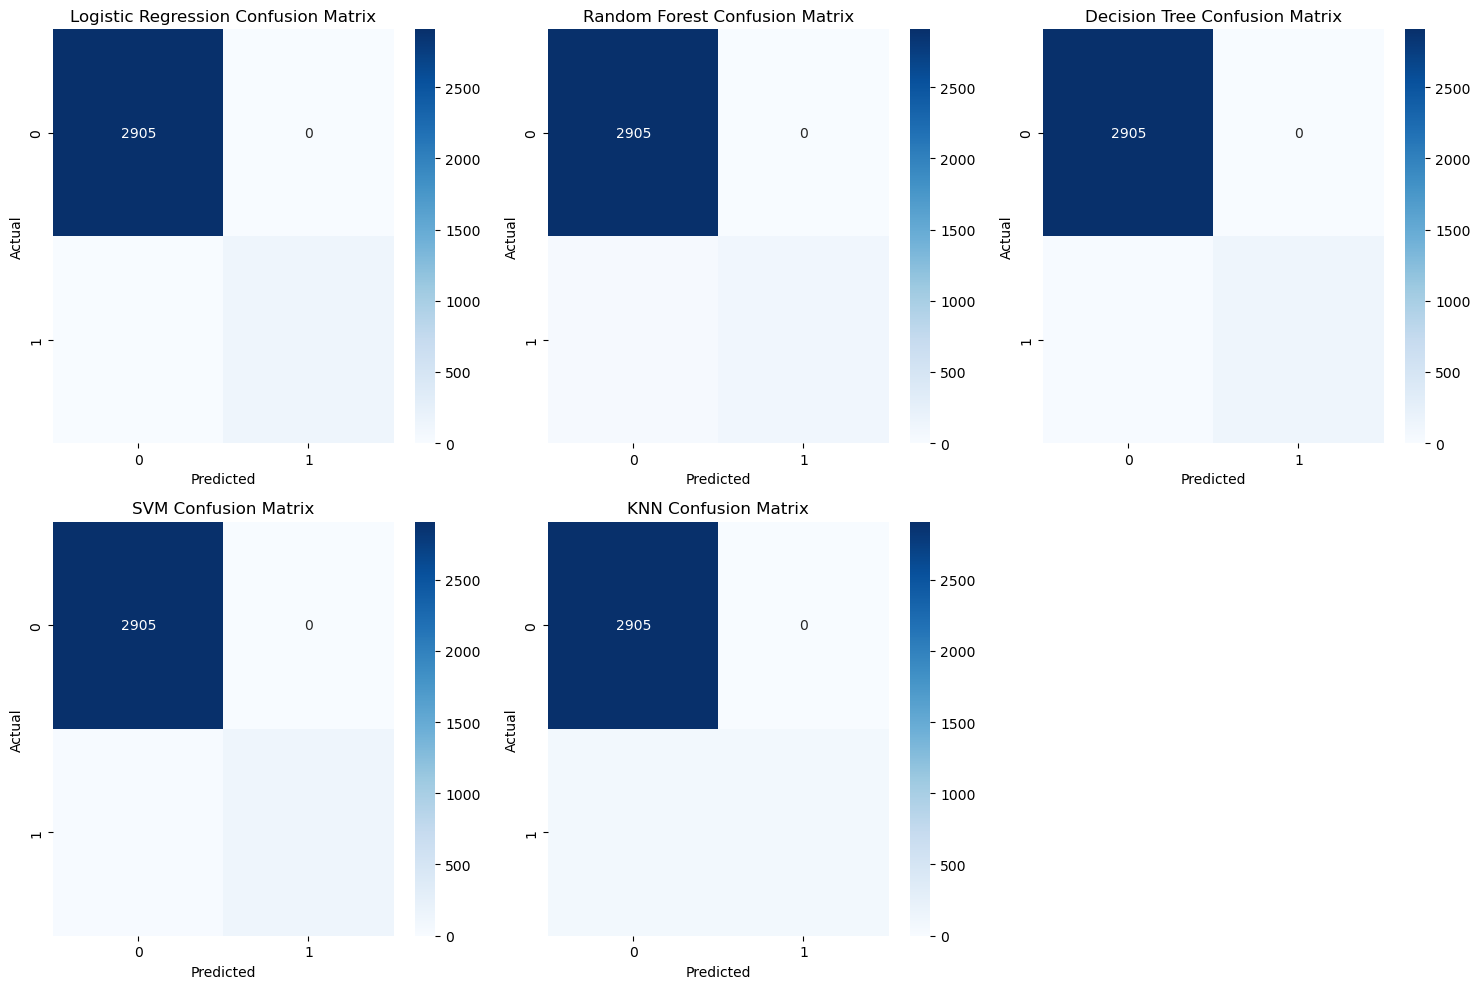

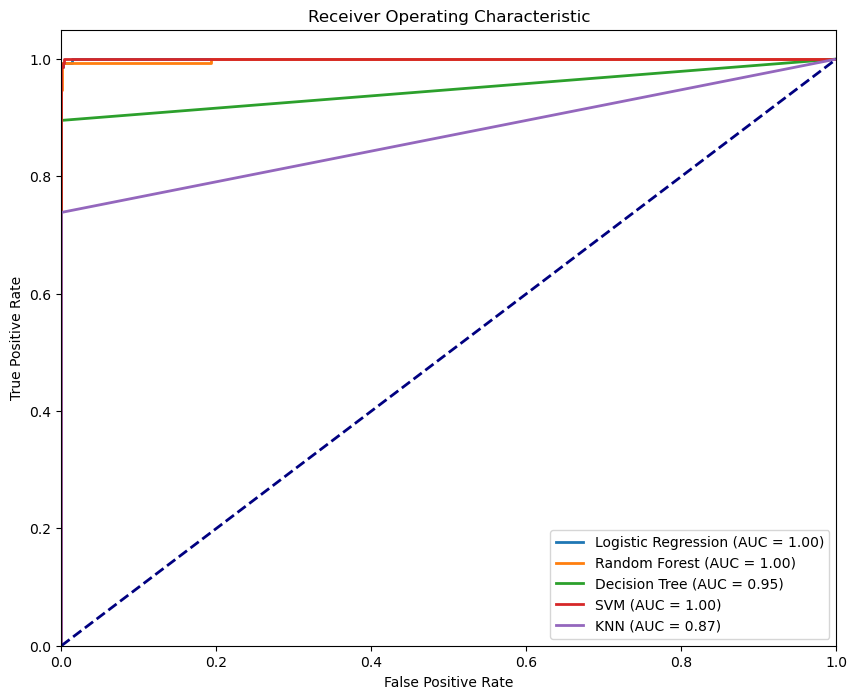

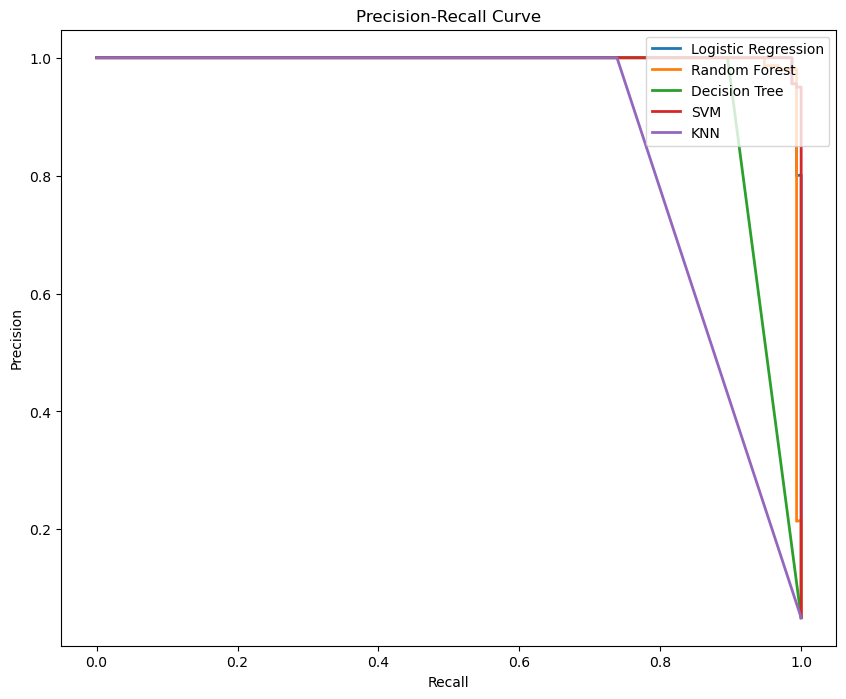

                     accuracy precision    recall        f1
Logistic Regression  0.997384       1.0  0.947712  0.973154
Random Forest        0.986266       1.0   0.72549  0.840909
Decision Tree        0.994768       1.0  0.895425  0.944828
SVM                  0.996076       1.0  0.921569  0.959184
KNN                  0.975801       1.0   0.51634  0.681034


In [2]:
# Plotting function
def plot_metrics(results):
    plt.figure(figsize=(15, 10))

    # Confusion Matrices
    for i, (model_name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        cm = confusion_matrix(y_test, models[model_name].predict(X_test_tfidf))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        plt.plot(result['fpr'], result['tpr'], lw=2, label=f'{model_name} (AUC = {result["roc_auc"]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        plt.plot(result['recall_vals'], result['precision_vals'], lw=2, label=model_name)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

# Plot results
plot_metrics(results)

# Display overall comparison
comparison = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1']]
print(comparison)

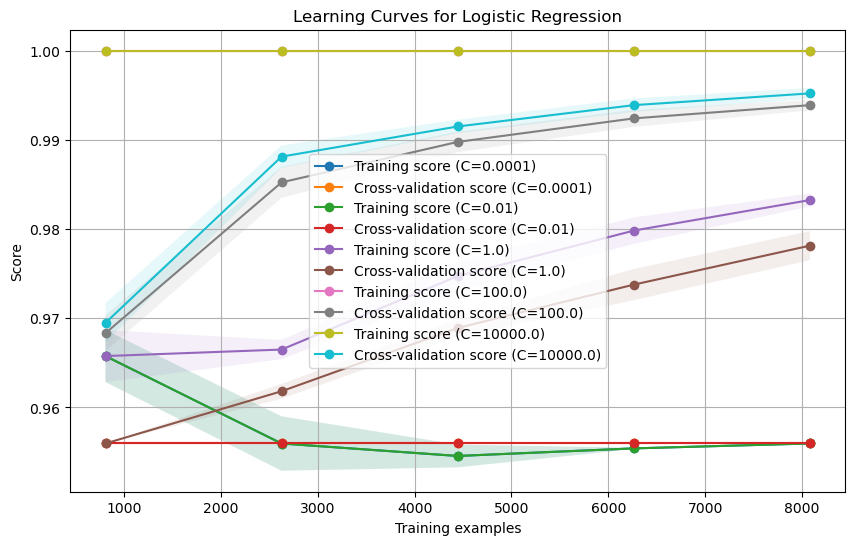

In [6]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title, hyperparam_values, scoring='accuracy'):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    for value in hyperparam_values:
        estimator.set_params(C=value)
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring=scoring)
        
        # Calculate mean and standard deviation for training set scores
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        
        # Calculate mean and standard deviation for test set scores
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1)
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
        plt.plot(train_sizes, train_scores_mean, 'o-', label=f"Training score (C={value})")
        plt.plot(train_sizes, test_scores_mean, 'o-', label=f"Cross-validation score (C={value})")

    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Call the plot function for Logistic Regression
logistic = LogisticRegression(solver='liblinear', max_iter=1000)
c_values = np.logspace(-4, 4, 5)  # Different values of C to plot
plot_learning_curve(logistic, X_train_tfidf, y_train, "Learning Curves for Logistic Regression", c_values)
